<a href="https://colab.research.google.com/github/Ana1890/Hibrido_nb1/blob/main/H%C3%ADbrido_nb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadificación de Alzheimer por medio de imágenes MRI utilizando redes neuronales

Dataset provisto por el sitio web de Kaggle: https://www.kaggle.com/tourist55/Alzheimers-dataset-4-class-of-images

El mismo está compuesto por imágenes MRI en formato .jpg y tienen cuatro clases tanto en sus datos de test como de train. Estas clases son:

* 1) Mild demented
* 2) Moderate demented
* 3) Non demented
* 4) Very mild demented

Para los datos de test tenemos:

* 179 imágenes Mild demented
* 12  imágenes Moderate demented
* 640 imágenes Non demented
* 448 imágenes very mild demented

Para los datos de train: 
* 717  imágenes Mild demented
* 52   imágened Moderate demented
* 2560 imágenes Non demented
* 1792 imágenes Very mild demented

Se intentará elevar el accuracy de un modelo de red neuronal residual evitando overfitting y probando de cambiar distintos parámetros tales como el número de épocas


In [1]:
!pip install progress

Accedemos a nuestro drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset')

In [4]:
!ls

test  train


In [5]:
!ls test

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [6]:
!ls train

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [7]:
# Librerías
from tqdm import tqdm
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
from skimage.io import imread, imsave

# Cargar datos

In [8]:
import os
import matplotlib.pyplot as plt
import cv2

FOLDER_PATH = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/train'
categories = sorted(os.listdir(FOLDER_PATH))
num_classes = 4

MILD_INDEX = categories.index("MildDemented")
MODERATE_INDEX = categories.index("ModerateDemented")
NON_INDEX = categories.index("NonDemented")
VERYMILD_INDEX = categories.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path = [list() for category in categories]

for index, category in enumerate(categories):
    category_path = os.path.join(FOLDER_PATH, category)

    # Recorrer imágenes
    images = [i for i in os.listdir(category_path)]
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        images_path[index].append(image_path)

print("Sobre el dataset")
for category_name, images in zip(categories, images_path):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 717
#Imagenes de la clase ModerateDemented: 52
#Imagenes de la clase NonDemented: 2560
#Imagenes de la clase VeryMildDemented: 1792


In [9]:
import os
import matplotlib.pyplot as plt
import cv2

FOLDER_PATH_TEST = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/test'
categories_test = sorted(os.listdir(FOLDER_PATH_TEST))
num_classes = 4

MILD_INDEX_TEST = categories_test.index("MildDemented")
MODERATE_INDEX_TEST = categories_test.index("ModerateDemented")
NON_INDEX_TEST = categories_test.index("NonDemented")
VERYMILD_INDEX_TEST = categories_test.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path_test = [list() for category in categories_test]

for index, category in enumerate(categories_test):
    category_path_test = os.path.join(FOLDER_PATH_TEST, category)

    # Recorrer imágenes
    images_test = [i for i in os.listdir(category_path_test)]
    for image_name in images_test:
        image_path_test = os.path.join(category_path_test, image_name)
        images_path_test[index].append(image_path_test)

print("Sobre el dataset")
for category_name, images in zip(categories_test, images_path_test):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 179
#Imagenes de la clase ModerateDemented: 12
#Imagenes de la clase NonDemented: 640
#Imagenes de la clase VeryMildDemented: 448


In [10]:
test_data = list()

for class_index, images_per_class in enumerate(images_path_test):
  test_data.extend([(img, class_index) for img in images_per_class])

* Las clases están muy desbalanceadas

## Visualización random

In [11]:
import random
random.seed(0)

def pick_randomly_file(image_list, ammount):
    max_length = len(image_list)
    chosen_images = []
    for _ in range(ammount):
        index = random.randint(0, max_length)
        chosen_images.append(image_list[index])
    
    return chosen_images


sample_images = 5
mild_sample = pick_randomly_file(images_path[MILD_INDEX], sample_images)
moderate_sample = pick_randomly_file(images_path[MODERATE_INDEX], sample_images)
non_sample = pick_randomly_file(images_path[NON_INDEX], sample_images)
Verymild_sample = pick_randomly_file(images_path[VERYMILD_INDEX], sample_images)


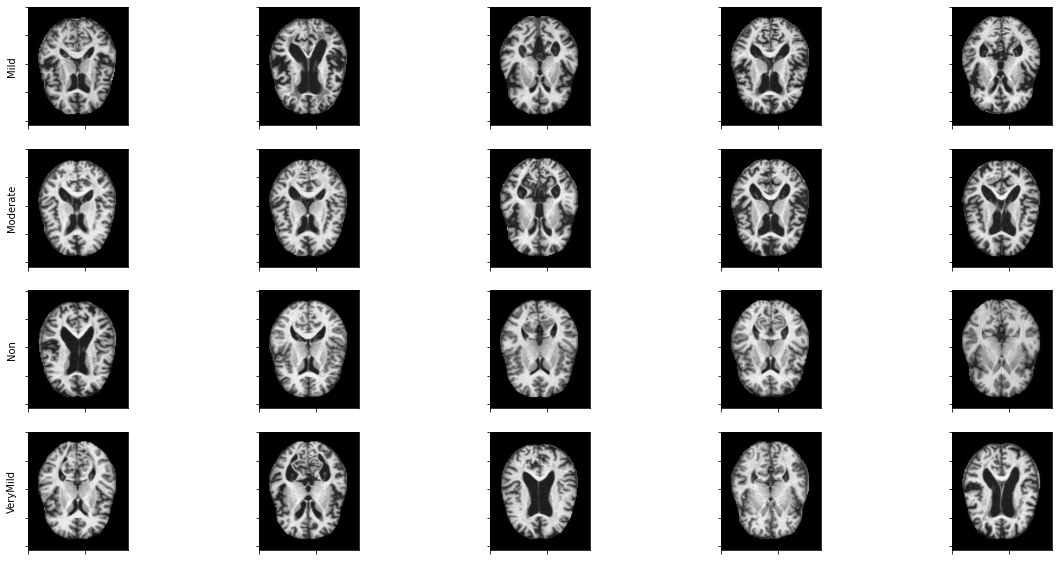

In [12]:
def visualize_sample(image_list, ax, title):
    ax[0].set_ylabel(title)
    for index in range(len(image_list)):        
        ax[index].imshow(cv2.imread(image_list[index]))
        ax[index].set_yticklabels([])
        ax[index].set_xticklabels([])


fx, ax = plt.subplots(num_classes,sample_images, figsize=(20,10))
visualize_sample(mild_sample, ax[0], "Mild")
visualize_sample(moderate_sample, ax[1], "Moderate")
visualize_sample(non_sample, ax[2], "Non")
visualize_sample(Verymild_sample, ax[3], "VeryMild")

plt.show()

In [13]:
image_s = [mild_sample, moderate_sample, non_sample, Verymild_sample]

for s in image_s:
  for l in s:
    print("El tamaño de la imagen ", s.index(l), "de la clase ", categories[image_s.index(s)], "es: ", (cv2.imread(l).size), "y la dimensión es: ", (cv2.imread(l).shape))


El tamaño de la imagen  0 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  0 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)


El conjunto de datos se encuentra desbalanceado, tiene imágenes de una dimensión de 208 x 176 x 3 dimensiones. Se podría pasar a 1 dimensión y de ahí normalizar, o tener 3 dimensiones y normalizarla directamente.

Pre-procesamiento: 
* Data Augmentation: Mild demented, Moderate demented
* Normalzación
* Visualización
* Reshape, binarización, morfología

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

In [15]:
train_data = list()

for class_index, images_per_class in enumerate(images_path):
  train_data.extend([(img, class_index) for img in images_per_class])

In [16]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):

    """MRI dataset."""

    def __init__(self, raw_data, input_size=(224,224)):
        self.raw_data = raw_data
        self.input_size = input_size
        self.images = list()
        self.annotations = list()
        self.transf = transforms.RandomAutocontrast()

        for path_to_image, label in self.raw_data:
            image_tensor = self._preprocess(path_to_image)
            target_tensor = torch.tensor(label)

            self.images.append(image_tensor)
            self.annotations.append(target_tensor)

    def _preprocess(self, path_to_image):
        '''
        Función dedicada a convertir nuestra imagen en números.
        Ademas también transforma la imagen en un tensor, que es necesario
        Para poder ser usado en el modelo.
        También se cambia el tamaño de la imagen para que sea uniforme en todas 
        las imágenes.
        '''

        img = cv2.imread(path_to_image)
        img = cv2.resize(img, self.input_size)

        # Aquí podemos plantear pasar la imagen a escala de grises

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Aquí normalizamos
        img = img / 255.

        input_tensor = torch.from_numpy(img).reshape(3, self.input_size[0], self.input_size[1]).float()
        print("transforme a tensor")

        input_tensor = self.transf(input_tensor)
        print("transforme a sharpness")

        return input_tensor

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, index):
        sample = {'input': self.images[index], 'target': self.annotations[index]}
        return sample

# Creamos la red neuronal

In [17]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

model = models.resnet50(pretrained=True)

new_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
    
    model.layer1,
    model.layer2,
    model.layer3,
    *(list(model.layer4.children())[:-1]),

    nn.Conv2d(2048, 32, kernel_size=(1,1), stride=(1, 1), bias=False),
    nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(32*7*7,4),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4,4),
    nn.LogSoftmax(dim=1)

    ) 


https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

In [ ]:
# Capa 4 sin su última sub capa
# newmodel = torch.nn.Sequential(*(list(model.layer4.children())[:-1]))
# print(newmodel)

https://www.it-swarm-es.com/es/python/como-eliminar-la-ultima-capa-fc-de-un-modelo-resnet-en-pytorch/807243870/

# Definimos algunos hiperparámetros

In [18]:
# Hyperparameters
lr = 0.001              # Learning rate
input_size = (224,224)

# Select the device to use
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Send the model to the device
new_model = new_model.to(device)

# Create dataloader
from torch.utils.data import DataLoader

batch_size = 16

In [19]:
from torchsummary import summary

summary(new_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
dataset = MRIDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme a sharpness
transforme a tensor
transforme

In [21]:
import torch.optim as optim

# Create an optimizer
optimizer = optim.Adam(new_model.parameters(), lr=lr)

# Loss Function
criterion = nn.NLLLoss()

# Entrenamiento

In [22]:
import sys
from progress.bar import Bar

def train_model(new_model, train_data, criterion, optimizer, num_epochs=25):
    new_model.train()
    Bar.check_tty = False
    Bar.file = sys.stdout

    for epoch in range(num_epochs):

        total_loss = 0.0
        processed = 0
        bar = Bar('Training Model', max=len(dataloader))
        for index, data_dict in enumerate(dataloader):
            input_tensor = data_dict["input"]
            gt_tensor = data_dict["target"]

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)

            optimizer.zero_grad()
            output = new_model(input_tensor)
            loss = criterion(output, gt_tensor)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            processed += input_tensor.shape[0]
            Bar.suffix = 'Train: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(train_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()
        bar.finish()
    return new_model

In [23]:
model = train_model(new_model, train_data, criterion, optimizer, num_epochs = 20)

Training Model |################################| Train: [1][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 1.2703 
Training Model |################################| Train: [2][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 1.0976 
Training Model |################################| Train: [3][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 1.0412 
Training Model |################################| Train: [4][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 0.9934 
Training Model |################################| Train: [5][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 0.9652 
Training Model |################################| Train: [6][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 0.9498 
Training Model |################################| Train: [7][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 0.9253 
Training Model |################################| Train: [8][5121/5121]|Tot: 0:01:57 |ETA: 0:00:01 | Loss 0.9216 
Training Model |################################| Train: [9][5121/5121]|Tot: 0:01:57 |ET

# Pre procesamos datos nuevos

In [24]:
transfor = transforms.RandomAutocontrast()

def preprocess(path_to_image, label):
    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)    
    img = img / 255.
    input_tensor = torch.from_numpy(img).reshape(1, 3, input_size[0],input_size[1]).float()
    input_tensor = transfor(input_tensor)
    gt_tensor = torch.tensor([label])
    return input_tensor, gt_tensor

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [39]:
y_true = []
y_pred = []

def test_model(new_model, test_data):
    new_model = new_model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data

        input_tensor, _ = preprocess(img_path, target_class)
        input_tensor = input_tensor.to(device)
        output = new_model(input_tensor)
        prediction = torch.argmax(output).item()

        y_pred.append(prediction)
        y_true.append(target_class)

        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))

    print("\nReporte de clasificación: \n", classification_report(y_true, y_pred, target_names= categories))
    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=categories, yticklabels=categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

Testing Model |################################| Test: [5120/5121]|Tot: 0:02:12 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.0000
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.8891
Accuracy for class VeryMildDemented: 0.7227

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       717
ModerateDemented       0.00      0.00      0.00        52
     NonDemented       0.82      0.89      0.85      2560
VeryMildDemented       0.55      0.72      0.63      1792

        accuracy                           0.70      5121
       macro avg       0.34      0.40      0.37      5121
    weighted avg       0.60      0.70      0.65      5121


Matriz de confusión: 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


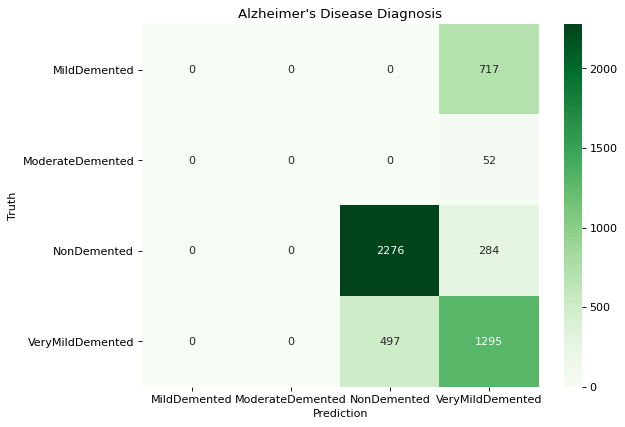

Testing Model |################################| Test: [1278/1279]|Tot: 0:00:33 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.0000
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.8203
Accuracy for class VeryMildDemented: 0.3594

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.76      0.88      0.82      3200
VeryMildDemented       0.53      0.65      0.59      2240

        accuracy                           0.67      6400
       macro avg       0.32      0.38      0.35      6400
    weighted avg       0.57      0.67      0.61      6400


Matriz de confusión: 



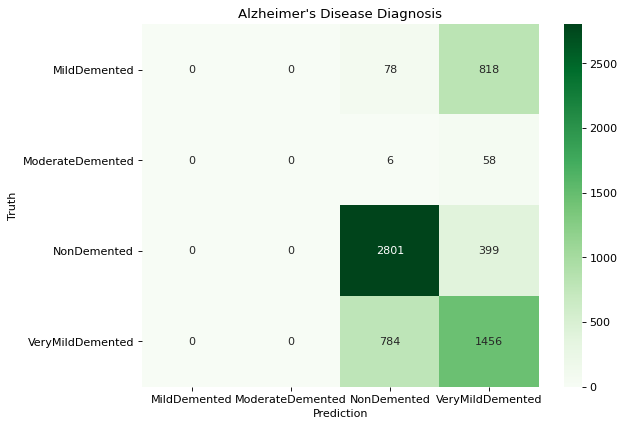

In [40]:

test_model(model, train_data)
test_model(model, test_data)

In [ ]:
#Este sí puede ser para probar (1)
def preprocess(path_to_image, input_size = (208,176)):

    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = img / 255
    input_tensor = torch.from_numpy(img).reshape(1, input_size[0],input_size[1]).float()
    
    return input_tensor

In [ ]:
#Este sí puede ser para probar (2)
for path_to_image, label in train_data:
    image_tensor = preprocess(path_to_image)
    target_tensor = torch.tensor(label)

KeyboardInterrupt: ignored

# Aumentación de datos

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/ 

https://medium.com/analytics-vidhya/image-data-augmentation-to-balance-dataset-in-classification-tasks-5e25bbd9a228